Problem Statement:  How stellar characteristics influence planetary system multiplicity by modeling the number of detected planets orbiting a star as a Poisson‑distributed count outcome, and estimating how changes in stellar mass, metallicity, and effective temperature affect that expected planet count?

In [ ]:
import pandas as pd

df = pd.read_csv("data.csv")

df = df.rename(columns={
    "sy_pnum": "Y",      # number of planets
    "st_mass": "T",      # stellar mass
    "st_met": "Z",       # metallicity
    "st_teff": "E"       # effective temperature
})

df.head()

,sy_name,hostname,Y,Stellar Parameter Reference,E,T,Z,st_metratio
0,14 Her,14 Her,2,TICv8,5280.0,0.91,0.40,[M/H]
1,16 Cyg,HIP 96895,1,TICv8,5778.0,1.04,0.09,[M/H]
2,16 Cyg,16 Cyg B,1,TICv8,5747.0,1.03,0.06,[M/H]
3,47 UMa,47 UMa,3,TICv8,5872.0,1.06,0.04,[M/H]
4,51 Peg,51 Peg,1,TICv8,5758.0,1.03,0.18,[M/H]


In [ ]:
df.describe()

,Y,E,T,Z
count,1617.000000,1615.000000,1617.000000,1617.000000
mean,1.443414,5594.919610,0.999742,0.026117
std,0.854180,537.510118,0.161499,0.212347
min,1.000000,3259.000000,0.164568,-1.050000
25%,1.000000,5310.405000,0.910000,-0.099800
50%,1.000000,5662.200000,1.008000,0.051500
75%,2.000000,5946.910000,1.090000,0.173300
max,8.000000,7852.930000,1.870000,0.470000


In [ ]:
df = df[["Y", "T", "Z", "E"]].dropna()

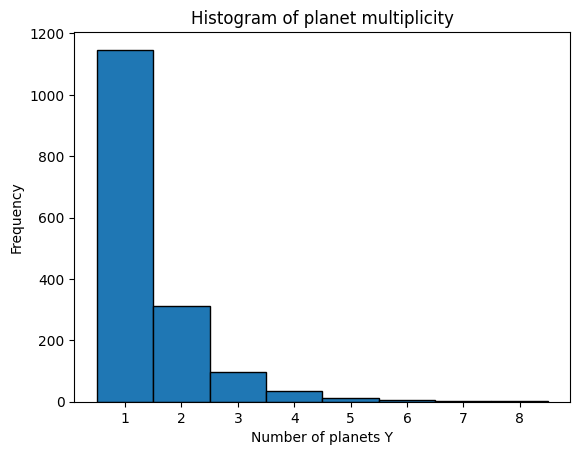

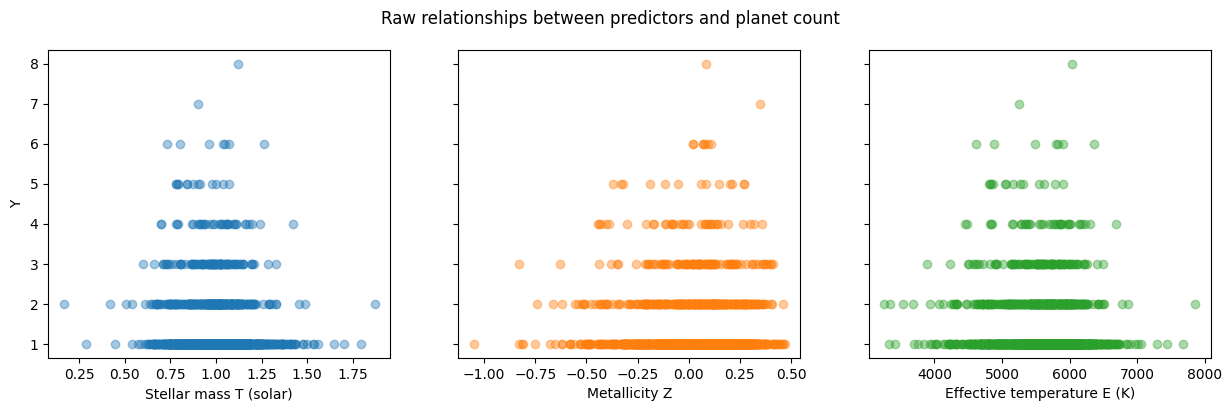

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df["Y"], bins=range(1, int(df["Y"].max()) + 2),
         align="left", edgecolor="black")
plt.xlabel("Number of planets Y")
plt.ylabel("Frequency")
plt.title("Histogram of planet multiplicity")
plt.show()

# Pairwise scatterplots for E, T, Z vs Y
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].scatter(df["T"], df["Y"], alpha=0.4)
axes[0].set_xlabel("Stellar mass T (solar)")
axes[0].set_ylabel("Y")

axes[1].scatter(df["Z"], df["Y"], alpha=0.4, color="tab:orange")
axes[1].set_xlabel("Metallicity Z")

axes[2].scatter(df["E"], df["Y"], alpha=0.4, color="tab:green")
axes[2].set_xlabel("Effective temperature E (K)")

fig.suptitle("Raw relationships between predictors and planet count")
plt.show()

In [ ]:
def standardize(s):
    return (s - s.mean()) / s.std()

df["T_std"] = standardize(df["T"])
df["Z_std"] = standardize(df["Z"])
df["E_std"] = standardize(df["E"])

model_df = df[["Y", "T_std", "Z_std", "E_std"]].copy()
model_df.head()
model_df.describe()

,Y,T_std,Z_std,E_std
count,1615.000000,1.615000e+03,1.615000e+03,1.615000e+03
mean,1.443344,4.069672e-17,1.319894e-17,4.531635e-16
std,0.854526,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-5.230800e+00,-5.098953e+00,-4.345815e+00
25%,1.000000,-5.667276e-01,-5.968637e-01,-5.293195e-01
50%,1.000000,4.644583e-02,1.178062e-01,1.251705e-01
75%,2.000000,5.595093e-01,6.956043e-01,6.548535e-01
max,8.000000,5.439870e+00,2.099843e+00,4.200870e+00


In [ ]:
Y_data = model_df["Y"].values
T_data = model_df["T_std"].values
Z_data = model_df["Z_std"].values
E_data = model_df["E_std"].values

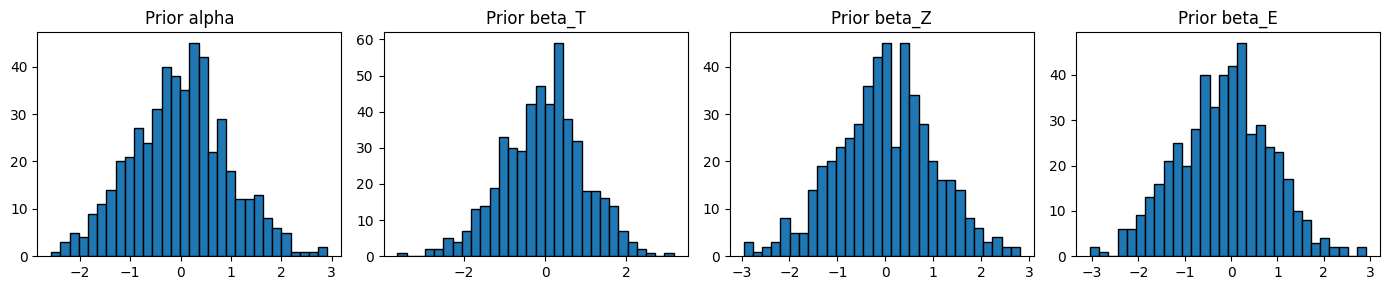

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng(42)

alpha_draws = rng.normal(0.0, 1.0, size=500)
betaT_draws = rng.normal(0.0, 1.0, size=500)
betaZ_draws = rng.normal(0.0, 1.0, size=500)
betaE_draws = rng.normal(0.0, 1.0, size=500)

fig, axes = plt.subplots(1, 4, figsize=(14, 3))
axes[0].hist(alpha_draws, bins=30, edgecolor="black")
axes[0].set_title("Prior alpha")

axes[1].hist(betaT_draws, bins=30, edgecolor="black")
axes[1].set_title("Prior beta_T")

axes[2].hist(betaZ_draws, bins=30, edgecolor="black")
axes[2].set_title("Prior beta_Z")

axes[3].hist(betaE_draws, bins=30, edgecolor="black")
axes[3].set_title("Prior beta_E")

plt.tight_layout()
plt.show()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.365,0.020,0.330,0.402,0.001,0.001,725.0,534.0,1.00
beta_T,-0.152,0.140,-0.406,0.139,0.007,0.005,465.0,431.0,1.01
beta_Z,-0.001,0.019,-0.041,0.035,0.001,0.001,860.0,579.0,1.00
beta_E,0.108,0.139,-0.153,0.385,0.007,0.005,457.0,474.0,1.01


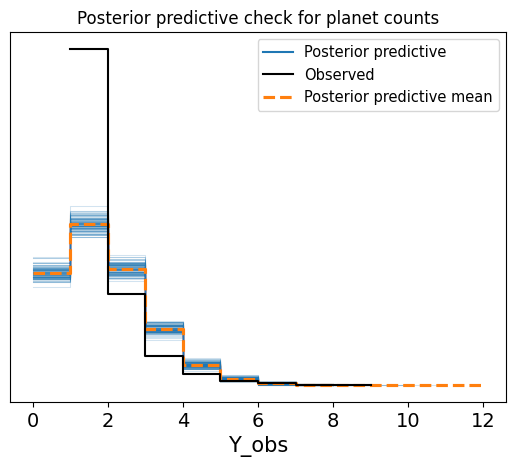

In [ ]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

Y_data = model_df["Y"].values
T_data = model_df["T_std"].values
Z_data = model_df["Z_std"].values
E_data = model_df["E_std"].values

# ---- Bayesian Poisson model + PPC ----
with pm.Model() as exo_model:
    # Priors
    alpha  = pm.Normal("alpha",  mu=0.0, sigma=1.0)
    beta_T = pm.Normal("beta_T", mu=0.0, sigma=1.0)
    beta_Z = pm.Normal("beta_Z", mu=0.0, sigma=1.0)
    beta_E = pm.Normal("beta_E", mu=0.0, sigma=1.0)

    # Linear predictor and mean
    eta = alpha + beta_T*T_data + beta_Z*Z_data + beta_E*E_data
    mu  = pm.Deterministic("mu", pm.math.exp(eta))

    # Poisson likelihood
    Y_obs = pm.Poisson("Y_obs", mu=mu, observed=Y_data)

    idata = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        random_seed=42,
        return_inferencedata=True,
    )

    idata = pm.sample_posterior_predictive(
        idata,
        extend_inferencedata=True,
        random_seed=42,
    )

idata_light = az.InferenceData(
    posterior=idata.posterior,
    posterior_predictive=idata.posterior_predictive,
    observed_data=idata.observed_data,
)

# Posterior summary of coefficients
summary = az.summary(
    idata_light,
    var_names=["alpha", "beta_T", "beta_Z", "beta_E"],
)
display(summary)

# Posterior predictive check plot
az.plot_ppc(
    idata_light,
    group="posterior",
    data_pairs={"Y_obs": "Y_obs"},
    num_pp_samples=100,
)
plt.title("Posterior predictive check for planet counts")
plt.show()

The posterior predictive plot shows the simulated multiplicity distribution (blue bands and orange mean curve) tracking the observed distribution very closely, especially for the dominant counts of 1–3 planets.​

There is no systematic under or over ‑ prediction at higher counts; the model reproduces the long right tail up to about 8–9 planets, which suggests that a single Poisson component with these predictors is adequate for the overall count distribution.

In [ ]:
import numpy as np

post = idata_light.posterior

# Convert log-coefficients to multiplicative effects
rr_T = np.exp(post["beta_T"].values).ravel()
rr_Z = np.exp(post["beta_Z"].values).ravel()
rr_E = np.exp(post["beta_E"].values).ravel()

def summarize_rr(x):
    return {
        "mean": x.mean(),
        "hdi_3":  np.quantile(x, 0.03),
        "hdi_97": np.quantile(x, 0.97),
    }

print("Rate ratio for mass (T_std):", summarize_rr(rr_T))
print("Rate ratio for metallicity (Z_std):", summarize_rr(rr_Z))
print("Rate ratio for temperature (E_std):", summarize_rr(rr_E))

Rate ratio for mass (T_std): {'mean': np.float64(0.8670913443376228), 'hdi_3': np.float64(0.6532760962878295), 'hdi_97': np.float64(1.1419699309665197)}
Rate ratio for metallicity (Z_std): {'mean': np.float64(0.9994742912308386), 'hdi_3': np.float64(0.9612240451108345), 'hdi_97': np.float64(1.0371684458130712)}
Rate ratio for temperature (E_std): {'mean': np.float64(1.125296325909506), 'hdi_3': np.float64(0.8365353831163611), 'hdi_97': np.float64(1.4602273293413464)}


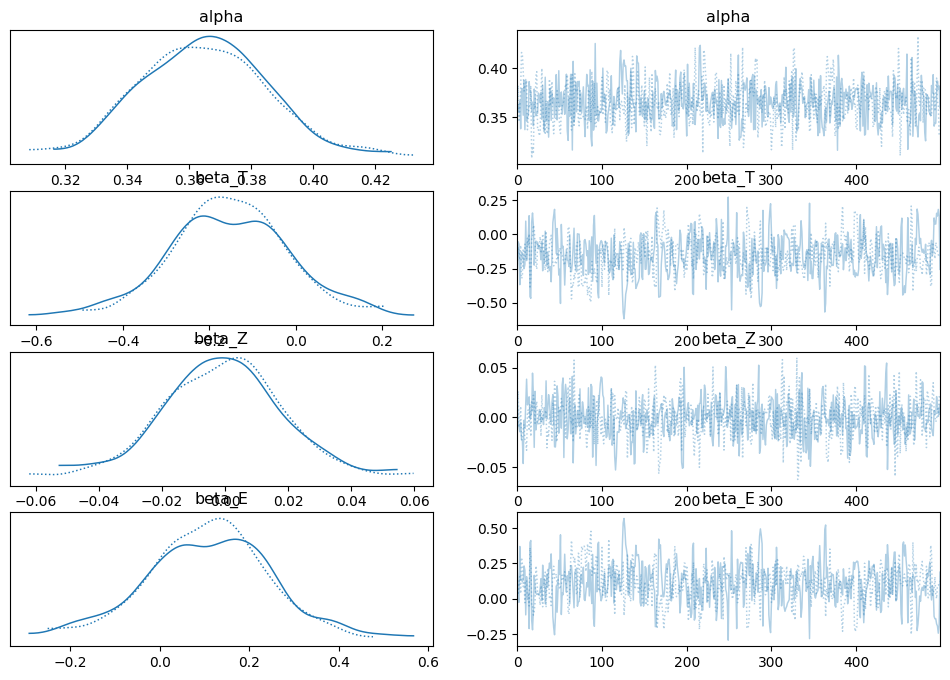

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_trace(
    idata_light,
    var_names=["alpha", "beta_T", "beta_Z", "beta_E"],
    compact=True
)
plt.show()

From the posterior and rate ratios plot, we can say the posterior mean of the intercept is α ≈ 0.365 with tight uncertainty, implying a baseline expected count of about exp ⁡ ( 0.365 ) ≈ 1.44 planets for a star with average standardized mass, metallicity, and temperature.​ The mass coefficient is β T ≈ − 0.15 with a 95% interval spanning roughly [−0.41,0.14], giving a rate ratio exp ( β T ) ≈ 0.86  but with uncertainty that crosses 1, so any negative association between stellar mass and multiplicity is weak and not clearly different from zero.​

Metallicity has β Z ≈ − 0.001 with a narrow interval around zero, corresponding to a rate ratio essentially equal to 1, which indicates no detectable effect of metallicity on how many planets a star hosts in this model.​

Effective temperature has β E ≈ 0.11 and a broad interval including zero, so a one–standard deviation hotter star might have about 11% higher expected planet count exp(0.11), but the posterior allows for both small positive and small negative effects, again suggesting no strong temperature dependence once mass and metallicity are controlled.​

The trace plots for all four parameters show well‑mixed chains with no visible non‑stationarity, and ArviZ reports R ^ ≈ 1.00 and effective sample sizes in the hundreds, which indicates good convergence of the NUTS sampler for this model.​ Posterior marginals are approximately unimodal and smooth, without heavy tails or multimodality, so summarizing by posterior means and 95% HDIs is appropriate for interpretation.

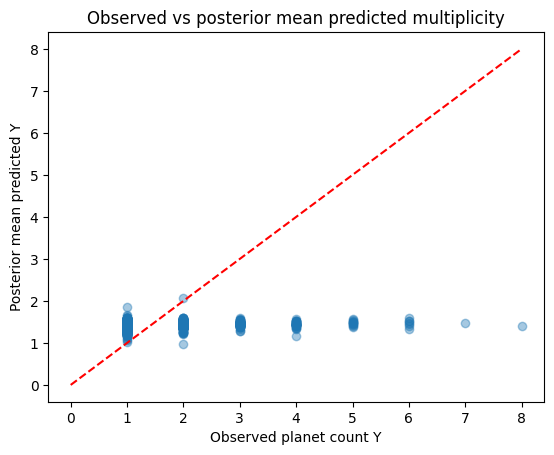

In [ ]:
# Posterior predictive draws: shape (chain, draw, obs)
y_post = idata_light.posterior_predictive["Y_obs"].values
y_post_mean = y_post.mean(axis=(0, 1))

plt.scatter(Y_data, y_post_mean, alpha=0.4)
m = max(Y_data.max(), y_post_mean.max())
plt.plot([0, m], [0, m], "r--")
plt.xlabel("Observed planet count Y")
plt.ylabel("Posterior mean predicted Y")
plt.title("Observed vs posterior mean predicted multiplicity")
plt.show()

The scatter plot of observed counts against posterior mean predicted counts lies below the 45‑degree line for systems with more than 2–3 planets, meaning the model tends to shrink extreme multiplicities back toward the overall mean of roughly 1–2 planets.​

For stars with 1 or 2 detected planets, the posterior means cluster tightly between 1 and 2, consistent with the empirical mode; for stars with 5–8 planets, the model predicts lower means around 1.5–2, reflecting both the rarity of such high counts and the Poisson structure, which cannot fully capture overdispersion at the extreme tail.

Conclusion: The model suggests that, within this sample of confirmed exoplanet systems, typical stars host about one to two detected planets on average, and neither higher mass, higher metallicity, nor higher effective temperature substantially changes that expected multiplicity once the other properties are accounted for; the Poisson GLM therefore serves more as a descriptive summary than evidence for strong causal effects of these stellar characteristics on planet counts.